### Prueba Coink - Cargo Científico de Datos
#### Febrero 2023

##### Postulante: Daniel León

### Punto 1.

**Objetivo**: Construir una métrica que evalúe qué tan buenos son los usuarios de Coink.

**Solución**: Considero que una métrica adecuada para evaluar la calidad de los usuarios es el Churn o Tasa de abandono, la cual por medio de las frecuencias de compra (en este caso, depósitos) de cada cliente, se puede estimar su respectiva probabilidad de abandono. 

De esta manera, esta métrica permitira definir aquellos clientes con probabilidad de abandono baja, para los cuales podemos definir estrategias comerciales de fidelización, mientras que para aquellos clientes con probabilidad de abandono (Churn) alta, se deben definir estrategias de retención o de reactivación.

**Metodología**: La actividad económica de Coink es no-contractual (non-contractual) debido a que los clientes no están vinculados con contratos de suscripción o de servicio recurrente. Esta situación no permite utilizar modelos de abandono tradicionales, debido a que el cliente puede terminar su relación con Coink en cualquier momento.

Por tanto, para el calculo del Churn usaré la metodología **Buy Til You Die**, la cual permite estimar la probabilidad de abancono para negocios no-contractuales, además de que permite estimar las compras futuras (depósitos) de cada cliente, y por tanto su Customer Lifetime Value.

Para información detallada acerca de la metodología por favor consultar el siguiente <a href="https://pypi.org/project/Lifetimes/" target="_blank"> enlace</a>

#### 1.1 Análisis exploratorio, limpieza y transformación de datos

In [1]:
## Importamos las librerías necesarias

# Instalar la primera vez
#!pip install lifetimes

import pandas as pd
import numpy as np

# Funciones necesarias para el calculo del Churn
from lifetimes import BetaGeoFitter, GammaGammaFitter
from lifetimes.utils import \
    calibration_and_holdout_data, \
    summary_data_from_transaction_data, \
    calculate_alive_path
from lifetimes.plotting import \
    plot_frequency_recency_matrix, \
    plot_probability_alive_matrix, \
    plot_period_transactions, \
    plot_history_alive, \
    plot_cumulative_transactions, \
    plot_calibration_purchases_vs_holdout_purchases, \
    plot_transaction_rate_heterogeneity, \
    plot_dropout_rate_heterogeneity

import warnings
warnings.filterwarnings("ignore")

pd.set_option("display.precision",2)

In [2]:
## Cargue dataset
df = pd.read_csv(r"C:\Users\dleon\Downloads\depositos_oinks.csv")

## Se elimina la primera columna correspondiente a un índice anterior
df = df.iloc[:,1:]
df.head()

,user_id,operation_value,operation_date,maplocation_name,user_createddate
0,0e52d550-ae23-407a-9b1f-6e5fb1f066ab,273850.0,2022-01-14 13:07:56,CC Plaza de las Américas - Plaza Mariposa,2022-01-09 19:23:18.332689
1,975ed41e-d891-4c23-aeba-06363019d8e3,900.0,2022-02-06 13:11:25,CC Plaza de las Américas - Plaza Mariposa,2022-01-10 15:19:29.419075
2,f9043545-dfc2-402f-a8c7-0a61f21cb719,1800.0,2022-02-23 14:01:56,Universidad de los Andes - ML Piso 5,2021-08-25 12:44:48.524941
3,979ca8ad-9600-4a1f-81e9-e70c2f55cdc5,6500.0,2021-12-16 12:09:45,CC Plaza de las Américas - Plaza Mariposa,2021-07-17 17:11:16.766291
4,171db06e-2e4b-4542-a9c9-32028520fda4,150000.0,2022-01-25 12:00:18,CC Plaza de las Américas - Plaza Mariposa,2022-01-11 15:59:27.651994


In [3]:
# Información general del dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4345 entries, 0 to 4344
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   user_id           4345 non-null   object 
 1   operation_value   4345 non-null   float64
 2   operation_date    4345 non-null   object 
 3   maplocation_name  4345 non-null   object 
 4   user_createddate  4345 non-null   object 
dtypes: float64(1), object(4)
memory usage: 169.9+ KB


In [4]:
# Convertimos a date las variables 'operation_date' y 'user_createddate'
df['operation_date'] = pd.to_datetime(df['operation_date'])
df['user_createddate'] = pd.to_datetime(df['user_createddate'])

In [5]:
print(f'Número de registros: {len(df)}')
print(f'Número de columnas: {df.shape[1]}')

print(f'Número de usuarios distintos: {df.user_id.nunique()}')
print(f'Número de lugares de depósito distintos: {df.maplocation_name.nunique()}')

print(f'Depósito mínimo realizado (pesos col): {df.operation_value.min()}')
print(f'Depósito máximo realizado (pesos col): {df.operation_value.max()}')
print(f'Mediana de los valores depositados (pesos col): {df.operation_value.median()}')

print(f'Fecha del depósito más antiguo: {df.operation_date.min()}')
print(f'Fecha del depósito más reciente: {df.operation_date.max()}')

print(f'Fecha creación del usuario más antiguo: {df.user_createddate.min()}')
print(f'Fecha creación del usuario más reciente: {df.user_createddate.max()}')


Número de registros: 4345
Número de columnas: 5
Número de usuarios distintos: 1656
Número de lugares de depósito distintos: 3
Depósito mínimo realizado (pesos col): 50.0
Depósito máximo realizado (pesos col): 2595000.0
Mediana de los valores depositados (pesos col): 5600.0
Fecha del depósito más antiguo: 2021-11-26 06:31:27
Fecha del depósito más reciente: 2022-02-24 15:32:50
Fecha creación del usuario más antiguo: 2019-08-25 22:56:16.354545
Fecha creación del usuario más reciente: 2022-02-23 17:48:28.112222


Con la breve exploración de datos realizada anteriormente, es posible obtener un contexto general del dataset a utilizar. Resalta el hecho de contar con información de 3 lugares de depósito distinto, para un periodo de tiempo de 3 meses. Asimismo, es interesante el rango de depósitos, desde COP 50 a COP 2.595.000, sin embargo, se observa que la mediana es de COP 5600.

In [6]:
# Transformación del dataset

# Para el modelamiento del Churn a realizar, solo se utilizaran tres variables: 
# - Fecha del depósito (operation_date)
# - Id del usuario (user_id)
# - Valor de los depósitos realizados en cada fecha de depósito (operation_value),
#   es decir, se suman los depósitos diarios realizados por cada cliente

# Eliminamos la hora de operation_date
df['operation_date'] = pd.to_datetime(df['operation_date'].dt.strftime("%Y-%m-%d"))

df_scoring = df[['user_id','operation_date','operation_value']].groupby(['user_id','operation_date']).sum()
df_scoring.reset_index(inplace=True)
df_scoring.head()

,user_id,operation_date,operation_value
0,001762e3-094d-415c-9304-c7c182e0c16a,2022-02-05,5000.0
1,001762e3-094d-415c-9304-c7c182e0c16a,2022-02-15,20450.0
2,001762e3-094d-415c-9304-c7c182e0c16a,2022-02-21,19300.0
3,002a5f4d-a93d-4cc5-b089-e16169bc16a2,2022-01-26,259000.0
4,006687d3-8ff3-461e-bdac-cb8e8e4c5a26,2021-12-15,375600.0


#### 1.2 Cálculo de métricas de Frecuencia, Recencia y Valor monetario

**Definición de métricas**

-	**Frecuencia (frequency):** Número de períodos de tiempo, después de la compra inicial, cuando el cliente vuelve a comprar (depositar).
-	**Recencia (recency):** Número de períodos de tiempo entre la primera y la última compra (depósito) de un cliente.
-	**T (Antiguedad del cliente):** Número de períodos de tiempo desde la primera compra del cliente (depósito).
-	**Valor monetario (monetary_value):** Valor promedio de las compras (depósitos) del cliente.
-	**Probabilidad de vida (prob_alive):** 1 - probabilidad de abandono.
-   **Tasa de abandono (Churn):** Probabilidad de 0 a 1 de que el cliente abandone.

In [7]:
# Fecha máxima de depósitos
max_date =  df_scoring["operation_date"].max()

# Calculo de métricas RFM
df_rft = summary_data_from_transaction_data(
    transactions = df_scoring, 
    customer_id_col = "user_id", 
    datetime_col = "operation_date",
    monetary_value_col = "operation_value", 
    observation_period_end = max_date, 
    freq = "D")

pd.options.display.float_format = '{:,.0f}'.format
df_rft.head()

,frequency,recency,T,monetary_value
user_id,,,,
001762e3-094d-415c-9304-c7c182e0c16a,2,16,19,"19,875"
002a5f4d-a93d-4cc5-b089-e16169bc16a2,0,0,29,0
006687d3-8ff3-461e-bdac-cb8e8e4c5a26,0,0,71,0
0072157e-a634-4cb3-bead-b1a2981485ca,1,14,33,"44,450"
0082af19-8bf7-46f7-8a21-c34e46ac5e2a,0,0,12,0


Se observa que el dataframe generado tiene las métricas de Frecuencia (frecuency), Recencia (recency), Antiguedad (T), y Valor monetario (monetary_value) para cada usuario (user_id)

In [8]:
## Descriptivos de las métricas calculadas
df_rft.describe()

,frequency,recency,T,monetary_value
count,"1,656","1,656","1,656","1,656"
mean,1,12,47,"16,204"
std,3,22,27,"71,679"
min,0,0,0,0
25%,0,0,23,0
50%,0,0,47,0
75%,1,15,73,"6,081"
max,47,89,90,"1,650,300"


Se observa que la frecuencia (frequency) promedio es de 1, es decir, luego del primer depósito, los usuarios en promedio solo realizaron un depósito adicional en ese periodo de tiempo. Sin embargo, se observa que la mediana de los usuarios (50%) tiene frecuencia 0, es decir, solo realizaron un depósito en el periodo de tiempo analizado.

Asimismo, la recencia (recency) promedio es de 12, es decir, hay 12 días en promedio entre el primer depósito y el último depósito.

Por último, se observa que el valor monetario (monetary_value) promedio es de COP 16.204.

#### 1.3 Predicción de compras

A partir de las métricas de cada cliente (recency, frequency y age(T)), el modelo permite pronosticar las siguientes compras esperadas para cada cliente en los próximos 30, 60 y 180 días.

In [9]:
# BG/NBD model
bgf = BetaGeoFitter()
bgf.fit(frequency = df_rft["frequency"], 
        recency = df_rft["recency"], 
        T = df_rft["T"])

def predict_purch(df, t):
        df["predict_purch_" + str(t)] = \
        bgf.predict(t, 
        df["frequency"], 
        df["recency"], 
        df["T"])
        
t_FC = [30, 60, 180]
_ = [predict_purch(df_rft, t) for t in t_FC]

pd.options.display.float_format = '{:,.1f}'.format
print("Número de depósitos predichos para cada usuario en los siguientes t días")
df_rft.head()

Número de depósitos predichos para cada usuario en los siguientes t días


,frequency,recency,T,monetary_value,predict_purch_30,predict_purch_60,predict_purch_180
user_id,,,,,,,
001762e3-094d-415c-9304-c7c182e0c16a,2.0,16.0,19.0,"19,875.0",1.9,3.5,8.7
002a5f4d-a93d-4cc5-b089-e16169bc16a2,0.0,0.0,29.0,0.0,0.2,0.4,1.0
006687d3-8ff3-461e-bdac-cb8e8e4c5a26,0.0,0.0,71.0,0.0,0.1,0.2,0.5
0072157e-a634-4cb3-bead-b1a2981485ca,1.0,14.0,33.0,"44,450.0",0.5,1.0,2.5
0082af19-8bf7-46f7-8a21-c34e46ac5e2a,0.0,0.0,12.0,0.0,0.4,0.7,1.7


In [10]:
print(f'Promedio de depósitos predichas por usuario en los próximos 30 días {round(df_rft.predict_purch_30.mean(),2)}')

Promedio de depósitos predichas por usuario en los próximos 30 días 0.63


Se observa que el modelo implementado permite predecir el número de depósitos predichos para cada usuario en los próximos días, lo cual también permitiría definir metas de depósito para cada usuario.

#### 1.3 Definición de la tasa de abandono (Churn) para cada usuario a partir de la estimación del modelo BG/NBD

In [11]:
prob_alive = bgf.conditional_probability_alive(
        frequency = df_rft["frequency"], 
        recency = df_rft["recency"], 
        T = df_rft["T"])

df_rft["prob_alive"] = prob_alive
df_rft["Churn"] = 1-prob_alive
df_rft.head()

,frequency,recency,T,monetary_value,predict_purch_30,predict_purch_60,predict_purch_180,prob_alive,Churn
user_id,,,,,,,,,
001762e3-094d-415c-9304-c7c182e0c16a,2.0,16.0,19.0,"19,875.0",1.9,3.5,8.7,0.8,0.2
002a5f4d-a93d-4cc5-b089-e16169bc16a2,0.0,0.0,29.0,0.0,0.2,0.4,1.0,1.0,0.0
006687d3-8ff3-461e-bdac-cb8e8e4c5a26,0.0,0.0,71.0,0.0,0.1,0.2,0.5,1.0,0.0
0072157e-a634-4cb3-bead-b1a2981485ca,1.0,14.0,33.0,"44,450.0",0.5,1.0,2.5,0.6,0.4
0082af19-8bf7-46f7-8a21-c34e46ac5e2a,0.0,0.0,12.0,0.0,0.4,0.7,1.7,1.0,0.0


Se observa que se cuenta con el calculo de la probabilidad de vida (prob_alive) y tasa de abandono (churn) para cada usuario. Sin embargo, es importante considerar que la probabilidad de vida es de 1 para los usuarios con frecuencia 0, es decir, con solo una compra durante el periodo de tiempo, esto debido a que el modelo no tiene como referencia un segundo periodo de tiempo para definir la periodicidad de depósito esperada para esos clientes.

In [12]:
## Se eliminan de los descriptivos los usuarios con frecuencia 0

clientes_frecuencia0 = len(df_rft[df_rft['frequency']==0])

print(f'Número de clientes con frecuencia 0: {clientes_frecuencia0}')
      
df_rft[df_rft['frequency']>0][['prob_alive','Churn']].describe()

Número de clientes con frecuencia 0: 998


,prob_alive,Churn
count,658.0,658.0
mean,0.6,0.4
std,0.2,0.2
min,0.0,0.0
25%,0.5,0.2
50%,0.7,0.3
75%,0.8,0.5
max,1.0,1.0


Se observa que la probabilidad de vida promedio es de 0.6, equivalente a una tasa de abandono del 0.4. Es decir, que en terminos generales existe un riesgo medio de abandono en los clientes analizados.

Sin embargo, es necesario considerar un **periodo de tiempo más amplio**, pues el periodo analizado fue de solo 3 meses.

#### 1.4 Conclusión

Si bien es necesario replicar este análisis con un periodo de tiempo más amplio, es posible concluir que existe un riesgo medio de abandono en los clientes analizados, con un número significativos de clientes con un solo depósito durante el periodo de tiempo analizado.

Así bien, de esta manera, se propone una métrica para evaluar la calidad de los usuarios de Coink, determinando su probabilidad de vida a partir de su comportamienti histórico de depósitos, lo cual permite definir estrategias de retención y fidelización específicas para la condición de cada usuario.

**Nota**: Es necesario calibrar algunos parametros del modelo implementado. Sin embargo, es algo que se realizaría teniendo el dataset completo de clientes y el periodo de tiempo completo.

### Punto 2

**Nota**: Mi experiencia con el despligue ha sido principalmente en Azure, por medio de Máquinas virtuales o servicios Azure como Azure WebApps. Por tanto, requeriría una leve curva de aprendizaje para encontrar el servicio similar en otras nubes como AWS, o Google.

Para realizar el proceso de despliegue de un modelo de ML, y su consumo por medio de una API, es necesario primero guardar en un archivo pickle (.pkl) o extensiones similares el modelo ya entrenado (independiente de si es supervisado o no supervisado). Posteriormente, por medio de Flask o de FastAPI, podemos crear una API que por medio del método GET o POST reciba los parámetros necesarios para el request de la API. Luego, usando Docker, generamos la imagen de todo el proyecto y usando una herramienta cloud como Azure WebApps  AWS, realizamos el despliegue en web de nuestra API. Finalmente, debemos realizar pruebas de su funcionamiento y entregar con la respectiva documentación de uso al área interesada.

### Punto 3

#### Objetivo: Desarrollar dos modelos de aprendizaje supervisado para predecir la variable JobSatisfaction

In [13]:
## Cargue de dataset
df2 = pd.read_excel(r"C:\Users\dleon\Downloads\info_satisfaccion_trabajo.xlsx")
df2.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


#### 3.1 Análisis exploratorio, limpieza y transformación de datos

**Nota**: Por cuestiones de tiempo, no se realizará una revisión detallada de la correlación de las variables, así como un entendimiento detallada de las variables del dataset.

In [14]:
print(f'Número de registros: {len(df2)}')
print(f'Número de columnas: {df2.shape[1]}')

Número de registros: 1470
Número de columnas: 35


In [15]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

Se observa que no hay valores perdidos en el dataset. Por tanto, se procede con la estandarización de las variables numéricas, y la dumificación de las variables categóricas.

In [16]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

vars_continuas = ['Age','DailyRate','DistanceFromHome','HourlyRate','MonthlyIncome','MonthlyRate','PercentSalaryHike','TotalWorkingYears','TrainingTimesLastYear','YearsAtCompany','YearsInCurrentRole','YearsSinceLastPromotion','YearsWithCurrManager']
vars_std = pd.DataFrame(scaler.fit_transform(df2[vars_continuas]),columns=vars_continuas)

vars_std.head()

,Age,DailyRate,DistanceFromHome,HourlyRate,MonthlyIncome,MonthlyRate,PercentSalaryHike,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,0.4,0.7,-1.0,1.4,-0.1,0.7,-1.2,-0.4,-2.2,-0.2,-0.1,-0.7,0.2
1,1.3,-1.3,-0.1,-0.2,-0.3,1.5,2.1,-0.2,0.2,0.5,0.8,-0.4,0.8
2,0.0,1.4,-0.9,1.3,-0.9,-1.7,-0.1,-0.6,0.2,-1.1,-1.2,-0.7,-1.2
3,-0.4,1.5,-0.8,-0.5,-0.8,1.2,-1.2,-0.4,0.2,0.2,0.8,0.3,-1.2
4,-1.1,-0.5,-0.9,-1.3,-0.6,0.3,-0.9,-0.7,0.2,-0.8,-0.6,-0.1,-0.6


In [17]:
vars_categoricas = ['Attrition','BusinessTravel','Department','Education','EducationField','EnvironmentSatisfaction','Gender','JobInvolvement','JobLevel','JobRole','MaritalStatus','OverTime','PerformanceRating','RelationshipSatisfaction','StockOptionLevel','WorkLifeBalance']

df2[vars_categoricas] = df2[vars_categoricas].astype('str')
vars_cat = pd.get_dummies(df2[vars_categoricas])

vars_cat.head()

,Attrition_No,Attrition_Yes,BusinessTravel_Non-Travel,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Department_Human Resources,Department_Research & Development,Department_Sales,Education_1,Education_2,...,RelationshipSatisfaction_3,RelationshipSatisfaction_4,StockOptionLevel_0,StockOptionLevel_1,StockOptionLevel_2,StockOptionLevel_3,WorkLifeBalance_1,WorkLifeBalance_2,WorkLifeBalance_3,WorkLifeBalance_4
0,0,1,0,0,1,0,0,1,0,1,...,0,0,1,0,0,0,1,0,0,0
1,1,0,0,1,0,0,1,0,1,0,...,0,1,0,1,0,0,0,0,1,0
2,0,1,0,0,1,0,1,0,0,1,...,0,0,1,0,0,0,0,0,1,0
3,1,0,0,1,0,0,1,0,0,0,...,1,0,1,0,0,0,0,0,1,0
4,1,0,0,0,1,0,1,0,1,0,...,0,1,0,1,0,0,0,0,1,0


In [18]:
y = df2[['JobSatisfaction']].astype(int)

X = pd.concat([vars_std,vars_cat],axis=1)
X.head()

,Age,DailyRate,DistanceFromHome,HourlyRate,MonthlyIncome,MonthlyRate,PercentSalaryHike,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,...,RelationshipSatisfaction_3,RelationshipSatisfaction_4,StockOptionLevel_0,StockOptionLevel_1,StockOptionLevel_2,StockOptionLevel_3,WorkLifeBalance_1,WorkLifeBalance_2,WorkLifeBalance_3,WorkLifeBalance_4
0,0.4,0.7,-1.0,1.4,-0.1,0.7,-1.2,-0.4,-2.2,-0.2,...,0,0,1,0,0,0,1,0,0,0
1,1.3,-1.3,-0.1,-0.2,-0.3,1.5,2.1,-0.2,0.2,0.5,...,0,1,0,1,0,0,0,0,1,0
2,0.0,1.4,-0.9,1.3,-0.9,-1.7,-0.1,-0.6,0.2,-1.1,...,0,0,1,0,0,0,0,0,1,0
3,-0.4,1.5,-0.8,-0.5,-0.8,1.2,-1.2,-0.4,0.2,0.2,...,1,0,1,0,0,0,0,0,1,0
4,-1.1,-0.5,-0.9,-1.3,-0.6,0.3,-0.9,-0.7,0.2,-0.8,...,0,1,0,1,0,0,0,0,1,0


#### 3.2 Modelo supervisado 1: Modelo de regresión - XgBoost Regressor

**Nota**: En un modelo productivo, sería necesario hacer validación cruzada y grid search, asegurando la consistencia del modelo para todo el dataset, y los mejores hiperparámetros del modelo. Asimismo, serían necesario probar distintos algoritmos, y no solo uno como en este caso.

In [19]:
#!pip install xgboost
from sklearn.model_selection import train_test_split
import xgboost as xg
from sklearn.metrics import classification_report, mean_absolute_percentage_error, mean_squared_error as MSE

In [20]:
## Definición de conjuntos de entrenamiento y prueba
train_X, test_X, train_y, test_y = train_test_split(X, y,test_size = 0.3, random_state = 123)

In [21]:
xgb_r = xg.XGBRegressor(objective ='reg:linear',n_estimators = 10, seed = 123)

# Ajuste del modelo
xgb_r.fit(train_X, train_y)

# Predicción del modelo
pred = xgb_r.predict(test_X)

# Cálculo de la métrica de desempeño RMSE
rmse = np.sqrt(MSE(test_y, pred))
print("RMSE : % f" %(rmse))

[17:22:11] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
RMSE :  1.164171


Se observa que el desempeño del modelo según el resultado obtenido en RMSE tiene margen de mejora.

#### 3.2.1 Análisis de los resultados obnetidos usando SHAP values

Los modelos de Machine Learning suelen ser cajas negras que dificultan su interpretación. Para comprender cuáles son las características principales que afectan el resultado del modelo, necesitamos técnicas de aprendizaje automático explicable que desentrañen algunos de estos aspectos.

Una de estas técnicas es el método SHAP, que se utiliza para explicar cómo cada característica (variable) afecta el modelo.

SHAP values (SHapley Additive exPlanations) es un método basado en la teoría de juegos cooperativos y se utiliza para aumentar la transparencia y la interpretabilidad de los modelos de aprendizaje automático.

SHAP muestra la contribución o la importancia de cada característica en la predicción del modelo, no evalúa la calidad de la predicción en sí.

Permutation explainer: 442it [00:28, 10.42it/s]                                                                        


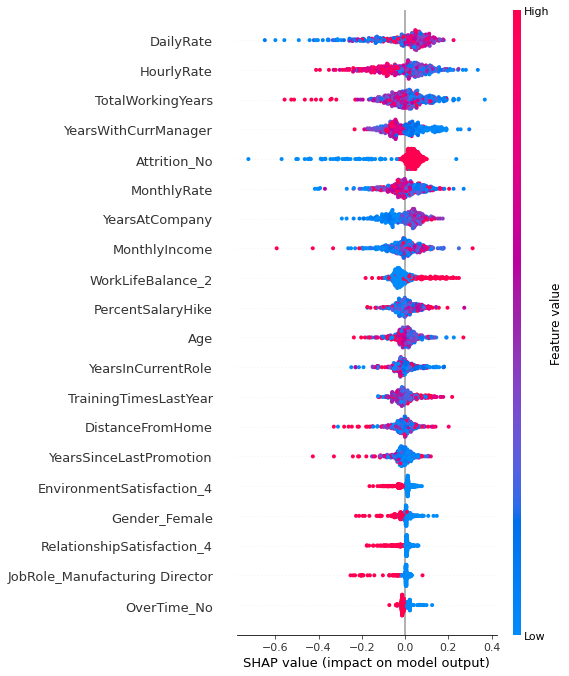

In [22]:
#!pip install shap

import shap
explainer = shap.Explainer(xgb_r.predict,test_X)
shap_values = explainer(test_X)
# summarize the effects of all the features
shap.summary_plot(shap_values)

La interpretación del gráfico anterior es la siguiente, en el eje x tenemos el impacto de cada variable sobre la predicción del modelo, donde valores positivos incrementan el valor predicho, y valores negativos reducen el valor predicho. Por otro lado, tenemos un indicativo de los valores altos (en rojo) y bajos (en azul) para cada registro del dataset en cada una de las variables.

De esta manera, se observa que la variable con mayor importancia en el modelo es **DailyRate**, en la cual valores altos están relacionados con valores más altos en la predicción (JobSatisfaction).

#### 3.3 Modelo supervisado 2: Modelo de clasificación - XGBoost Classifier

In [23]:
xgb_clf = xg.XGBClassifier()

# Se transforma la variable de salida, para que inicie en 0, según los requerimientos de XGBoost
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train_y = le.fit_transform(train_y)
test_y = le.transform(test_y)

# Ajuste del modelo
xgb_clf.fit(train_X, train_y)

# Predicción del modelo
pred = xgb_clf.predict(test_X)
predictions = [round(value) for value in pred]

# Cálculo de la métrica de desempeño Accuracy
print(classification_report(test_y, pred))

              precision    recall  f1-score   support

           0       0.16      0.10      0.12        84
           1       0.17      0.12      0.14        94
           2       0.28      0.35      0.31       132
           3       0.32      0.40      0.36       131

    accuracy                           0.27       441
   macro avg       0.23      0.24      0.23       441
weighted avg       0.25      0.27      0.25       441



Se observa que el desempeño del modelo de clasificación no es bueno, teniendo un accuracy y un f1-score bastante bajo.

Permutation explainer: 442it [00:44,  7.52it/s]                                                                        


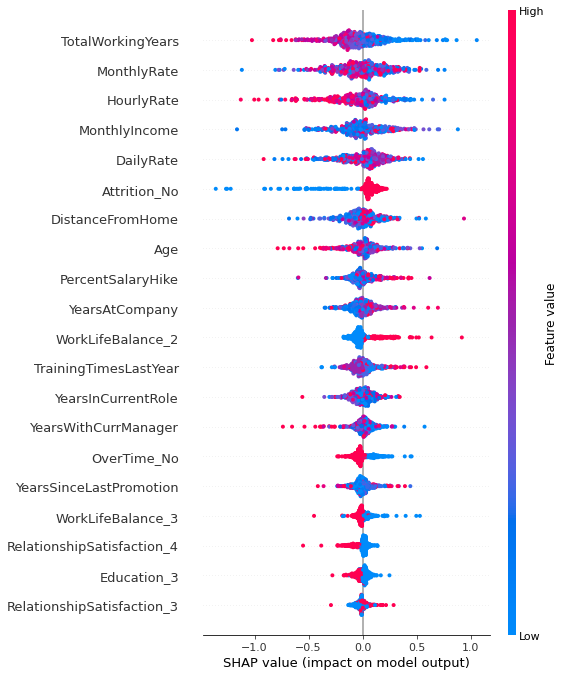

In [24]:
import shap
explainer = shap.Explainer(xgb_clf.predict,test_X)
shap_values = explainer(test_X)
# summarize the effects of all the features
shap.summary_plot(shap_values)

Para el caso del modelo de clasificación, se observa que la variable más importante en el modelo es **TotalWorkingYears**, donde valores bajos de esta variable están relacionados con valores más altos en la predicción de la satisfacción del trabajo (JobSatisfaction), es decir, las personas con menos años de trabajo están más satisfechas con su trabajo.

#### Monitoreo del modelo luego del despliegue

Una vez se haya desplegado el modelo, se deben realizar dos tipos de monitoreo: El monitoreo técnico de disponibilidad, es decir, si desplegamos por medio de API o una tarea automatizada debemos asegurar su correcto funcionamiento. Por otro lado, el segundo tipo de monitoreo está relacionado con la calidad de la predicción, para lo cual podríamos planear calibraciones del modelo (es decir, un reentrenamiento) de manera periódica (mensual, por ejemplo), para actualizar la información considerada en el entrenamiento. Adicionalmente, podemos realizar calibraciones adicionales si encontramos undesvío significativo de la predicción con respecto a los valores reales.